# Personally Identifiable Information (PII) Data Detec

#### The dataset comprises approximately 22,000 essays written by students enrolled in a massively open online course. All of the essays were written in response to a single assignment prompt, which asked students to apply course material to a real-world problem. 

#### The goal is to annotate personally identifiable information (PII) found within the essays.

#### There are seven types of PII:

* *NAME_STUDENT* - The full or partial name of a student that is not necessarily the author of the essay. This excludes instructors, authors, and other person names.
* *EMAIL* - A student’s email address.
* *USERNAME* - A student's username on any platform.
* *ID_NUM* - A number or sequence of characters that could be used to identify a student, such as a student ID or a social security number.
* *PHONE_NUM* - A phone number associated with a student.
* *URL_PERSONAL* - A URL that might be used to identify a student.
* *STREET_ADDRESS* - A full or partial street address that is associated with the student, such as their home address.

In [1]:
# upgrade to keras v3
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # # you can also use tensorflow or torch

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import json
import math

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import keras_nlp
import tensorflow as tf
from keras import ops

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
import plotly.express as px

2024-02-27 18:48:05.332872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 18:48:05.332935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 18:48:05.334468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasNLP: 0.7.0


In [4]:
class InputData:
    train = "/kaggle/input/pii-detection-removal-from-educational-data/train.json"
    test = "/kaggle/input/pii-detection-removal-from-educational-data/test.json"
    sample = "/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv"
    trained_model = "/kaggle/input/pii-detection-removal-from-educational-data/model.weights.h5"

In [5]:
train_data = pd.read_json(InputData.train)
test_data = pd.read_json(InputData.test)
all_data = pd.concat([train_data, test_data])

print(f"train data shape: {train_data.shape}")
print(f"test data shape: {test_data.shape}")
print(f"total shape of data: {all_data.shape}")

train data shape: (6807, 5)
test data shape: (10, 4)
total shape of data: (6817, 5)


In [6]:
all_data.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [7]:
all_data.tokens[0].values[0][:12]

['Design',
 'Thinking',
 'for',
 'innovation',
 'reflexion',
 '-',
 'Avril',
 '2021',
 '-',
 'Nathalie',
 'Sylla',
 '\n\n']

In [8]:
all_data.labels[0].values[0][:12]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NAME_STUDENT',
 'I-NAME_STUDENT',
 'O']

In [9]:
# Unique labels in dataframe
unique_labels = set()
for row in range(len(train_data)):
    unique_labels = unique_labels.union(set(train_data.iloc[row].labels))
print(unique_labels)

{'B-USERNAME', 'B-ID_NUM', 'I-PHONE_NUM', 'I-ID_NUM', 'I-NAME_STUDENT', 'B-EMAIL', 'I-STREET_ADDRESS', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'O', 'I-URL_PERSONAL', 'B-PHONE_NUM', 'B-NAME_STUDENT'}


In [10]:
# QTY of unique labels in dataframe
train_label_count = dict()
for row in range(len(train_data)):
    for label in train_data.iloc[row].labels:
        train_label_count[label] = train_label_count.get(label, 0) + 1
train_label_count = dict(sorted(train_label_count.items(), key=lambda x: x[1], reverse=True))
        
print('Quantity of each label:')
print(train_label_count)

Quantity of each label:
{'O': 4989794, 'B-NAME_STUDENT': 1365, 'I-NAME_STUDENT': 1096, 'B-URL_PERSONAL': 110, 'B-ID_NUM': 78, 'B-EMAIL': 39, 'I-STREET_ADDRESS': 20, 'I-PHONE_NUM': 15, 'B-USERNAME': 6, 'B-PHONE_NUM': 6, 'B-STREET_ADDRESS': 2, 'I-URL_PERSONAL': 1, 'I-ID_NUM': 1}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


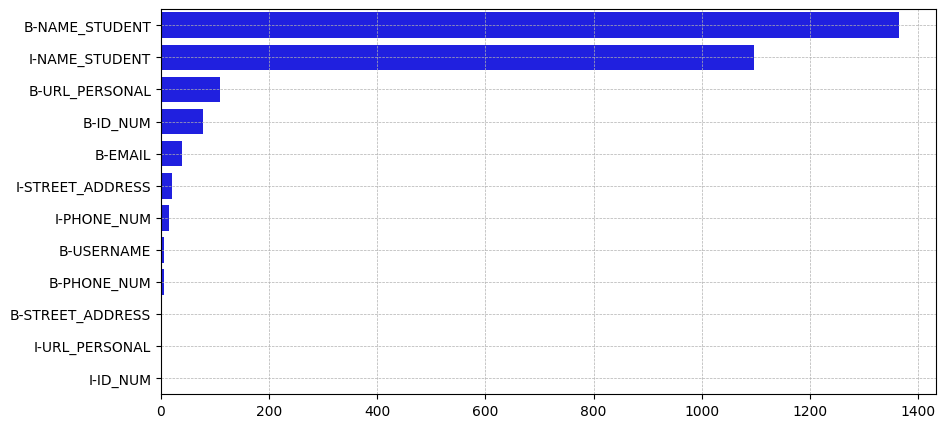

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(train_label_count.values())[1:], y=list(train_label_count.keys())[1:], color='blue')
plt.grid(True, linestyle='--', linewidth=0.5)

In [12]:
entities = [ent for ent in set([key[2:] for key in train_label_count]) - {''}]
print(entities)

['URL_PERSONAL', 'NAME_STUDENT', 'ID_NUM', 'STREET_ADDRESS', 'PHONE_NUM', 'USERNAME', 'EMAIL']


In [13]:
distr_of_labels = {
    'begin': [train_label_count.get('B-'+i,0) for i in entities],
    'end': [train_label_count.get('I-'+i,0) for i in entities]
                  }
distr_of_labels_df = pd.DataFrame(data=distr_of_labels, index=entities)
distr_of_labels_df

,begin,end
URL_PERSONAL,110,1
NAME_STUDENT,1365,1096
ID_NUM,78,1
STREET_ADDRESS,2,20
PHONE_NUM,6,15
USERNAME,6,0
EMAIL,39,0


In [14]:
from collections import Counter
from spacy.tokens import Doc
nlp = spacy.blank('en')

def find_first_occurence(entity_):
    for i in range(len(train_data)):
        train_label_count_ = Counter(train_data.iloc[i]['labels'])
        if 'B-'+entity_ in train_label_count_:
            break
    return i

def render_entities(record_):
    doc = Doc(nlp.vocab, words=record_['tokens'], spaces=record_['trailing_whitespace'], ents=record_['labels'])
    spacy.displacy.render(doc, style='ent')
    
'''
# render only the first occurance for all entities
for entity in entities:
    record = train_data.iloc[find_first_occurence(entity)]
    print()
    print()
    print(f"Record {find_first_occurence(entity)} showing the first {entity}")
    print()
    print()
    render_entities(record)
'''
render_entities(train_data.iloc[54])

Text(0.5, 1.0, 'Articles with and without labels')

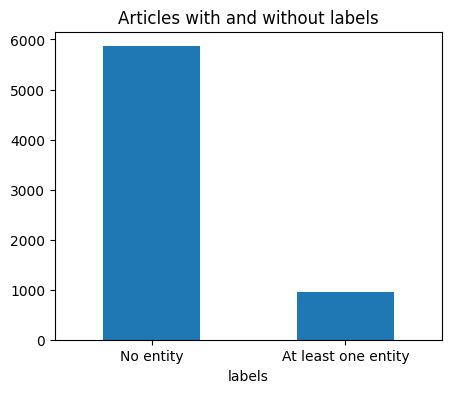

In [15]:
plt.figure(figsize=(5,4))
train_data['labels'].apply(lambda x: "No entity" if set(x) == {"O"} else "At least one entity").value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title("Articles with and without labels")

In [5]:
class ModelConfiguration:
    seed = 2024
    preset = 'deberta_v3_small_en'  # pretrained model
    train_seq_len = 1024       # max size of input
    train_batch_size = 8   # size of input batch
    infer_seq_len = 2000       # max size of input sequence for inference
    infer_batch_size = 2   # size of input batch in inference
    epochs = 6                 # number of epochs to train
    lr_mode = 'exp' # or 'cos' or 'step'
    
    labels = ['B-USERNAME', 'B-ID_NUM', 'I-PHONE_NUM', 'I-ID_NUM', 'I-NAME_STUDENT', 'B-EMAIL', 'I-STREET_ADDRESS', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'O', 'I-URL_PERSONAL', 'B-PHONE_NUM', 'B-NAME_STUDENT']
    id2label = dict(enumerate(labels))  # integer values for BIO mapping
    label2id = {value:key for key,value in id2label.items()}
    num_labels = len(labels)  # number of PII tags
    
    train = True  # whether to train or use already trained 

keras.utils.set_random_seed(ModelConfiguration.seed)      # produce similar result in each run
keras.mixed_precision.set_global_policy("mixed_float16")  # enable larger batch sizes and faster training

In [6]:
# Initialize empty arrays
data = json.load(open(InputData.train))

words = np.empty(len(data), dtype=object)
labels = np.empty(len(data), dtype=object)

# Fill the arrays
for i, x in tqdm(enumerate(data), total=len(data)):
    words[i] = np.array(x["tokens"])
    labels[i] = np.array([ModelConfiguration.label2id[label] for label in x["labels"]])

  0%|          | 0/6807 [00:00<?, ?it/s]

In [7]:
# split the data
train_tokens, valid_tokens, train_labels, valid_labels = train_test_split(
    words,
    labels,
    test_size = 0.3
)

In [8]:
# To convert string input or list of strings input to numerical tokens
tokenizer = keras_nlp.models.DebertaV3Tokenizer.from_preset(
    ModelConfiguration.preset,
)

# Preprocessing layer to add spetical tokens: [CLS], [SEP], [PAD]
packer = keras_nlp.layers.MultiSegmentPacker(
    start_value=tokenizer.cls_token_id,
    end_value=tokenizer.sep_token_id,
    sequence_length=10,
)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


In [9]:
# example of tokenizing
sample_words = words[0][:5]
sample_tokens_int = [
    token.tolist() for word in sample_words for token in tokenizer(word)
]
sample_tokens_str = [tokenizer.id_to_token(token) for token in sample_tokens_int]

print("words        :", sample_words.tolist())
print("tokens (str) :", sample_tokens_str)
print("tokens (int) :", sample_tokens_int)

words        : ['Design', 'Thinking', 'for', 'innovation', 'reflexion']
tokens (str) : ['▁Design', '▁Thinking', '▁for', '▁innovation', '▁reflex', 'ion']
tokens (int) : [2169, 12103, 270, 3513, 28310, 4593]


In [10]:
# example of preprocessing
padded_sample_tokens_int = packer(np.array(sample_tokens_int))[0].tolist()
padded_sample_tokens_str = [
    tokenizer.id_to_token(token) for token in padded_sample_tokens_int
]

print("tokens (str)        :", sample_tokens_str)
print("padded tokens (str) :", padded_sample_tokens_str, "\n")

print("tokens (int)        :", sample_tokens_int)
print("padded tokens (int) :", padded_sample_tokens_int)

tokens (str)        : ['▁Design', '▁Thinking', '▁for', '▁innovation', '▁reflex', 'ion']
padded tokens (str) : ['[CLS]', '▁Design', '▁Thinking', '▁for', '▁innovation', '▁reflex', 'ion', '[SEP]', '[PAD]', '[PAD]'] 

tokens (int)        : [2169, 12103, 270, 3513, 28310, 4593]
padded tokens (int) : [1, 2169, 12103, 270, 3513, 28310, 4593, 2, 0, 0]


In [11]:
# DATA PROCESSING FUNCTIONS
def get_tokens(words, seq_len, packer):
    # Tokenize input
    token_words = tf.expand_dims(
        tokenizer(words), axis=-1
    )  # ex: (words) ["It's", "a", "cat"] ->  (token_words) [[1, 2], [3], [4]]
    tokens = tf.reshape(
        token_words, [-1]
    )  # ex: (token_words) [[1, 2], [3], [4]] -> (tokens) [1, 2, 3, 4]
    # Pad tokens
    tokens = packer(tokens)[0][:seq_len]
    inputs = {"token_ids": tokens, "padding_mask": tokens != 0}
    return inputs, tokens, token_words


def get_token_ids(token_words):
    # Get word indices
    word_ids = tf.range(tf.shape(token_words)[0])
    # Get size of each word
    word_size = tf.reshape(tf.map_fn(lambda word: tf.shape(word)[0:1], token_words), [-1])
    # Repeat word_id with size of word to get token_id
    token_ids = tf.repeat(word_ids, word_size)
    return token_ids


def get_token_labels(word_labels, token_ids, seq_len):
    # Create token_labels from word_labels ->  alignment
    token_labels = tf.gather(word_labels, token_ids)
    # Only label the first token of a given word and assign -100 to others
    mask = tf.concat([[True], token_ids[1:] != token_ids[:-1]], axis=0)
    token_labels = tf.where(mask, token_labels, -100)
    # Truncate to max sequence length
    token_labels = token_labels[: seq_len - 2]  # -2 for special tokens ([CLS], [SEP])
    # Pad token_labels to align with tokens (use -100 to pad for loss/metric ignore)
    pad_start = 1  # for [CLS] token
    pad_end = seq_len - tf.shape(token_labels)[0] - 1  # for [SEP] and [PAD] tokens
    token_labels = tf.pad(token_labels, [[pad_start, pad_end]], constant_values=-100)
    return token_labels


def process_token_ids(token_ids, seq_len):
    # Truncate to max sequence length
    token_ids = token_ids[: seq_len - 2]  # -2 for special tokens ([CLS], [SEP])
    # Pad token_ids to align with tokens (use -1 to pad for later identification)
    pad_start = 1  # [CLS] token
    pad_end = seq_len - tf.shape(token_ids)[0] - 1  # [SEP] and [PAD] tokens
    token_ids = tf.pad(token_ids, [[pad_start, pad_end]], constant_values=-1)
    return token_ids


def process_data(seq_len=720, has_label=True, return_ids=False):
    # To add spetical tokens: [CLS], [SEP], [PAD]
    packer = keras_nlp.layers.MultiSegmentPacker(
        start_value=tokenizer.cls_token_id,
        end_value=tokenizer.sep_token_id,
        sequence_length=seq_len,
    )

    def process(x):
        # Generate inputs from tokens
        inputs, tokens, words_int = get_tokens(x["words"], seq_len, packer)
        # Generate token_ids for maping tokens to words
        token_ids = get_token_ids(words_int)
        if has_label:
            # Generate token_labels from word_labels
            token_labels = get_token_labels(x["labels"], token_ids, seq_len)
            return inputs, token_labels
        elif return_ids:
            # Pad token_ids to align with tokens
            token_ids = process_token_ids(token_ids, seq_len)
            return token_ids
        else:
            return inputs

    return process

In [12]:
# DATA LOADING FUNCTION
def build_dataset(words, labels=None, return_ids=False, batch_size=4,
                  seq_len=512, shuffle=False, cache=True, drop_remainder=True):
    AUTO = tf.data.AUTOTUNE 

    slices = {"words": tf.ragged.constant(words)}
    if labels is not None:
        slices.update({"labels": tf.ragged.constant(labels)})

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(process_data(seq_len=seq_len,
                             has_label=labels is not None, 
                             return_ids=return_ids), num_parallel_calls=AUTO) # apply processing
    ds = ds.cache() if cache else ds  # cache dataset
    if shuffle: # shuffle dataset
        ds = ds.shuffle(1024, seed=ModelConfiguration.seed)  
        opt = tf.data.Options() 
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # batch dataset
    ds = ds.prefetch(AUTO)  # prefetch next batch
    return ds

In [13]:
# BUILD TRAIN AND VALID DATALOADER
train_ds = build_dataset(train_tokens, train_labels,  batch_size=ModelConfiguration.train_batch_size,
                         seq_len=ModelConfiguration.train_seq_len, shuffle=True)

valid_ds = build_dataset(valid_tokens, valid_labels, batch_size=ModelConfiguration.train_batch_size, 
                         seq_len=ModelConfiguration.train_seq_len, shuffle=False)

In [14]:
# DATASET CHECK
inp, tar = next(iter(valid_ds))
print("# Input:\n",inp); print("\n# Labels:\n",tar)

# Input:
 {'token_ids': <tf.Tensor: shape=(8, 1024), dtype=int32, numpy=
array([[     1, 116069,  71864, ...,      0,      0,      0],
       [     1, 116069, 101059, ...,      0,      0,      0],
       [     1,   4735,  16508, ...,      0,      0,      0],
       ...,
       [     1,  45730,    377, ...,      0,      0,      0],
       [     1,  53779,  24315, ...,      0,      0,      0],
       [     1,  51146,   6738, ...,      0,      0,      0]], dtype=int32)>, 'padding_mask': <tf.Tensor: shape=(8, 1024), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>}

# Labels:
 tf.Tensor(
[[-100    9 -100 ... -100 -100 -100]
 [-100    9 -100 ... -100 -100 -100]
 [-100    9    

In [15]:
# LOSS AND METRICS
class CrossEntropy(keras.losses.SparseCategoricalCrossentropy):
    def __init__(self, ignore_class=-100, reduction=None, **args):
        super().__init__(reduction=reduction, **args)
        self.ignore_class = ignore_class

    def call(self, y_true, y_pred):
        y_true = ops.reshape(y_true, [-1])
        y_pred = ops.reshape(y_pred, [-1, ModelConfiguration.num_labels])
        loss = super().call(y_true, y_pred)
        if self.ignore_class is not None:
            valid_mask = ops.not_equal(
                y_true, ops.cast(self.ignore_class, y_pred.dtype)
            )
            loss = ops.where(valid_mask, loss, 0.0)
            loss = ops.sum(loss)
            loss /= ops.maximum(ops.sum(ops.cast(valid_mask, loss.dtype)), 1)
        else:
            loss = ops.mean(loss)
        return loss
    
class FBetaScore(keras.metrics.FBetaScore):
    def __init__(self, ignore_classes=[-100, 12], average="micro", beta=5.0,
                 name="f5_score", **args):
        super().__init__(beta=beta, average=average, name=name, **args)
        self.ignore_classes = ignore_classes or []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = ops.convert_to_tensor(y_true, dtype=self.dtype)
        y_pred = ops.convert_to_tensor(y_pred, dtype=self.dtype)
        
        y_true = ops.reshape(y_true, [-1])
        y_pred = ops.reshape(y_pred, [-1, ModelConfiguration.num_labels])
            
        valid_mask = ops.ones_like(y_true, dtype=self.dtype)
        if self.ignore_classes:
            for ignore_class in self.ignore_classes:
                valid_mask &= ops.not_equal(y_true, ops.cast(ignore_class, y_pred.dtype))
        valid_mask = ops.expand_dims(valid_mask, axis=-1)
        
        y_true = ops.one_hot(y_true, ModelConfiguration.num_labels)
        
        if not self._built:
            self._build(y_true.shape, y_pred.shape)

        threshold = ops.max(y_pred, axis=-1, keepdims=True)
        y_pred = ops.logical_and(
            y_pred >= threshold, ops.abs(y_pred) > 1e-9
        )

        y_pred = ops.cast(y_pred, dtype=self.dtype)
        y_true = ops.cast(y_true, dtype=self.dtype)
        
        tp = ops.sum(y_pred * y_true * valid_mask, self.axis)
        fp = ops.sum(y_pred * (1 - y_true) * valid_mask, self.axis)
        fn = ops.sum((1 - y_pred) * y_true * valid_mask, self.axis)
            
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

In [16]:
# BUILDING THE MODEL
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    ModelConfiguration.preset,
)
out = backbone.output
out = keras.layers.Dense(ModelConfiguration.num_labels, name="logits")(out)
out = keras.layers.Activation("softmax", dtype="float32", name="prediction")(out)
model = keras.models.Model(backbone.input, out)

# Compile model for optimizer, loss and metric
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss=CrossEntropy(),
    metrics=[FBetaScore()],
)

# Summary of the model architecture
model.summary()

Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_small_en/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_embedding     │ (None, None, 768) │ 98,380… │ token_ids[0][0]      │
│ (ReversibleEmbeddi… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embeddings_layer_n… │ (None, None, 768) │   1,536 │ token_embedding[0][… │
│ (LayerNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embeddings_dropout  │ (None, None, 768) │       0 │ embeddings_layer_no… │
│ (Dropout)           │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rel_embedding       │ (None, 512, 768)  │ 394,752 │ embeddings_dropout[… │
│ (RelativeEmbedding) │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ embeddings_dropout[… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ disentangled_attent… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ disentangled_attent… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ disentangled_attent… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ disentangled_attent… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ disentangled_atten… │ (None, None, 768) │ 7,087,… │ disentangled_attent… │
│ (DisentangledAtten… │                   │         │ padding_mask[0][0],  │
│                     │                   │         │ rel_embedding[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ logits (Dense)      │ (None, None, 13)  │   9,997 │ disentangled_attent… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ prediction          │ (None, None, 13)  │       0 │ logits[0][0]         │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 141,314,317 (539.07 MB)

 Trainable params: 141,314,317 (539.07 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# LEARNING RATE SETUP
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 6e-6, 2.5e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        fig = px.line(x=np.arange(epochs),
                      y=[lrfn(epoch) for epoch in np.arange(epochs)], 
                      title='LR Scheduler',
                      markers=True,
                      labels={'x': 'epoch', 'y': 'lr'})
        fig.update_layout(
            yaxis = dict(
                showexponent = 'all',
                exponentformat = 'e'
            )
        )
        fig.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [18]:
lr_cb = get_lr_callback(ModelConfiguration.train_batch_size, mode=ModelConfiguration.lr_mode, plot=True)

In [19]:
# TRAINING
if ModelConfiguration.train:
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=ModelConfiguration.epochs,
        callbacks=[lr_cb],
        verbose=1,
    )
else:
    model.load_weights(InputData.trained_model)

Epoch 1/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 574s 918ms/step - f5_score: 0.9230 - loss: 0.2538 - val_f5_score: 0.9997 - val_loss: 0.0022 - learning_rate: 6.0000e-06
Epoch 2/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 494s 831ms/step - f5_score: 0.9997 - loss: 0.0017 - val_f5_score: 0.9998 - val_loss: 9.3687e-04 - learning_rate: 1.0667e-05
Epoch 3/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 473s 796ms/step - f5_score: 0.9999 - loss: 6.0337e-04 - val_f5_score: 0.9999 - val_loss: 5.3211e-04 - learning_rate: 1.5333e-05
Epoch 4/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 469s 788ms/step - f5_score: 0.9999 - loss: 3.3912e-04 - val_f5_score: 0.9999 - val_loss: 4.7493e-04 - learning_rate: 2.0000e-05
Epoch 5/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 465s 782ms/step - f5_score: 1.0000 - loss: 1.5363e-04 - val_f5_score: 0.9999 - val_loss: 5.0607e-04 - learning_rate: 1.5250e-05
Epoch 6/6
595/595 ━━━━━━━━━━━━━━━━━━━━ 462s 776ms/step - f5_score: 1.0000 - loss: 1.0014e-04 - val_f5_score: 0.9999 - val_loss: 4.2321e-04 - learning_rate: 1.1687e-05


In [23]:
model.save_weights("model.weights.h5")

In [25]:
# EVALUATION
valid_ds = build_dataset(valid_tokens, valid_labels, return_ids=False, batch_size=ModelConfiguration.infer_batch_size,
                        seq_len=ModelConfiguration.infer_seq_len, shuffle=False, cache=False)

model.evaluate(valid_ds, return_dict=True, verbose=0)

{'f5_score': 0.9999120235443115, 'loss': 0.00043810781789943576}

In [26]:
# PREPARE TEST DATA
# Test data
test_data = json.load(open(InputData.test))
    
# Initialize empty arrays
test_words = np.empty(len(test_data), dtype=object)
test_docs = np.empty(len(test_data), dtype=np.int32)

# Fill the arrays
for i, x in tqdm(enumerate(test_data), total=len(test_data)):
    test_words[i] = np.array(x["tokens"])
    test_docs[i] = x["document"]

# Get token ids
id_ds = build_dataset(test_words, return_ids=True, batch_size=len(test_words), 
                        seq_len=ModelConfiguration.infer_seq_len, shuffle=False, cache=False, drop_remainder=False)
test_token_ids = ops.convert_to_numpy([ids for ids in iter(id_ds)][0])

# Build test dataloader
test_ds = build_dataset(test_words, return_ids=False, batch_size=ModelConfiguration.infer_batch_size,
                        seq_len=ModelConfiguration.infer_seq_len, shuffle=False, cache=False, drop_remainder=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
# INFERENCE
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels via max confidence
test_preds = np.argmax(test_preds, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [34]:
# POST PROCESSING
document_list = []
token_id_list = []
label_id_list = []
token_list = []

for doc, token_ids, preds, tokens in tqdm(
    zip(test_docs, test_token_ids, test_preds, test_words), total=len(test_words)
):
    # Create mask for filtering
    mask1 = np.concatenate(([True], token_ids[1:] != token_ids[:-1])) # ignore non-start tokens of a word
    mask2 = (preds != 9)                                             # ignore `O` (BIO format) label -> 9 (integer format) label
    mask3 = (token_ids != -1)                                         # ignore [CLS], [SEP], and [PAD] tokens
    mask = (mask1 & mask2 & mask3)                                    # merge filters
    
    # Apply filter
    token_ids = token_ids[mask]
    preds = preds[mask]

     # Store prediction if number of tokens is not zero
    if len(token_ids):
        token_list.extend(tokens[token_ids])
        document_list.extend([doc] * len(token_ids))
        token_id_list.extend(token_ids)
        label_id_list.extend(preds)

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
# SUBMISSION
pred_df = pd.DataFrame(
    {
        "document": document_list,
        "token": token_id_list,
        "label_id": label_id_list,
        "token_string": token_list,
    }
)
pred_df = pred_df.rename_axis("row_id").reset_index() # add `row_id` column
pred_df["label"] = pred_df.label_id.map(ModelConfiguration.id2label) # map integer label to BIO format label
pred_df.head(10)

,row_id,document,token,label_id,token_string,label
0,0,7,9,12,Nathalie,B-NAME_STUDENT
1,1,7,10,4,Sylla,I-NAME_STUDENT
2,2,7,482,12,Nathalie,B-NAME_STUDENT
3,3,7,483,4,Sylla,I-NAME_STUDENT
4,4,7,741,12,Nathalie,B-NAME_STUDENT
5,5,7,742,4,Sylla,I-NAME_STUDENT
6,6,10,0,12,Diego,B-NAME_STUDENT
7,7,10,1,4,Estrada,I-NAME_STUDENT
8,8,10,464,12,Diego,B-NAME_STUDENT
9,9,10,465,4,Estrada,I-NAME_STUDENT


In [36]:
# SAVE FILE
sub_df = pred_df.drop(columns=["token_string", "label_id"]) # remove extra columns
sub_df.to_csv("submission.csv", index=False)

In [37]:
sub_df

,row_id,document,token,label
0,0,7,9,B-NAME_STUDENT
1,1,7,10,I-NAME_STUDENT
2,2,7,482,B-NAME_STUDENT
3,3,7,483,I-NAME_STUDENT
4,4,7,741,B-NAME_STUDENT
5,5,7,742,I-NAME_STUDENT
6,6,10,0,B-NAME_STUDENT
7,7,10,1,I-NAME_STUDENT
8,8,10,464,B-NAME_STUDENT
9,9,10,465,I-NAME_STUDENT
